In [1]:
import numpy as np
import gudhi
import mdtraj as md
import seaborn as sns
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
traj = md.load_dcd('decaD_prd.dcd', top='decaD_clean.pdb')
traj = md.Trajectory.superpose(traj, traj[0], frame=0, atom_indices=None, ref_atom_indices=None, parallel=True)

In [3]:
num_frames = min(traj.n_frames, 2000000)

selected_frames = range(0, num_frames, 10000)
selected_traj = traj[selected_frames]

# Save the selected trajectories into a new PDB file
selected_traj.save_pdb('bottleneck_selected_trajectory.pdb')

In [8]:
traj3 = md.load('bottleneck_selected_trajectory.pdb')
traj3 = md.Trajectory.superpose(traj3, traj3[0], frame=0, atom_indices=None, ref_atom_indices=None, parallel=True)

In [9]:
rmsd = md.rmsd(traj3, traj3[0], frame=0, atom_indices=None, parallel=True, precentered=False)*10

In [6]:
np.save('BottleneckRMSD.npy',rmsd2)

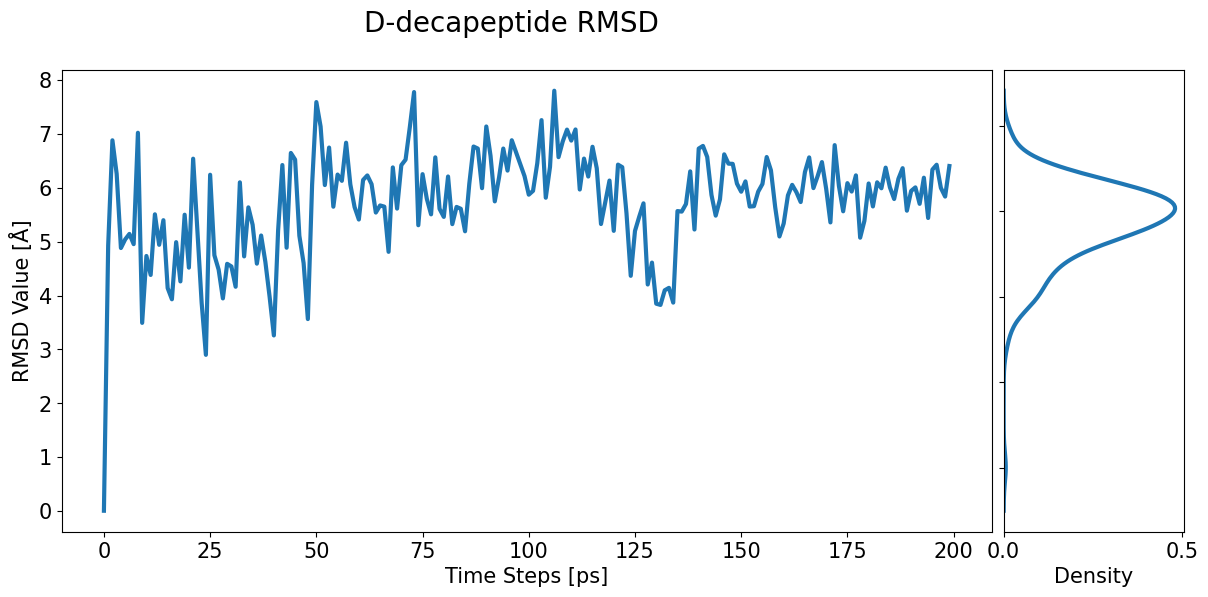

In [11]:
from pylab import *
from math import pi
time_steps = np.arange(0, 200)

fig, ax = plt.subplots(figsize=(12,6))
inty_ax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0,
                            0.15, ax.get_position().height])

ax.plot(time_steps, rmsd, marker='o', markersize=0, linestyle='-', lw=3)
ax.set_xlabel('Time Steps [ps]', fontsize = 15)
ax.set_ylabel('RMSD Value [Å]', fontsize = 15)
ax.tick_params(labelsize = 15)
sns.kdeplot(y = rmsd, ax = inty_ax, lw=3)
inty_ax.set_xlabel('Density', fontsize=15)
inty_ax.tick_params(labelleft = False, labelsize = 15)

fig.suptitle('D-decapeptide RMSD', fontsize = 20)
plot_filename = f'selected frame RMSD.png'
plt.savefig(plot_filename, bbox_inches='tight', dpi=900)
plt.show()

In [3]:
atomic_coordinates = traj.xyz

In [4]:
for frame in range(traj.n_frames):
    atomic_coordinates = traj.xyz[frame]

In [5]:
frame2 = traj.xyz[0]

In [6]:
carbon_atoms = traj.topology.select("element == 'C'")

In [7]:
frame1 = traj.xyz[0, carbon_atoms, :]

In [8]:
num_rows = np.size(frame1, axis=0)
print(f"Number of rows: {num_rows}")

Number of rows: 60


In [9]:
num_rows = np.size(frame2, axis=0)
print(f"Number of rows: {num_rows}")

Number of rows: 193


In [10]:
frame3 = traj.xyz[1047151, carbon_atoms, :]
frame4 = traj.xyz[1047151]

In [18]:
rips_complex = gudhi.RipsComplex(points=frame3)

In [19]:
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

In [20]:
persistence = simplex_tree.persistence()

In [29]:
alpha_complex = {tuple(sorted(simplex)) : radius for simplex, radius in simplex_tree.get_filtration()}
boundary_matrix = {simplex : set(itertools.combinations(simplex, len(simplex)-1))-{tuple()} for simplex in alpha_complex}

R = { k : v for k,v in boundary_matrix.items()}
V = { k : {k} for k in boundary_matrix}
lowinv = {} # lowinv[i]=index of column with the lowest 1 at i
order_function = lambda s: (alpha_complex[s], s)
for s in sorted(R, key=order_function):
    t = lowinv.get(max(R[s], key=order_function),-1) if len(R[s])!=0 else -1
    while t!=-1:
        R[s] = R[t]^R[s] # symmetric difference of t-th and s-th columns
        V[s] = V[t]^V[s]
        t = lowinv.get(max(R[s], key=order_function),-1) if len(R[s])!=0 else -1
    if len(R[s])!=0:
        lowinv[max(R[s], key=order_function)] = s

loops = [bar for bar in lowinv.items() if len(bar[0])==2]
longest_loop = max(loops, key=lambda bar: alpha_complex[bar[1]]-alpha_complex[bar[0]])
representative_1 = R[longest_loop[1]]
representative_2 = V[longest_loop[0]]
#for edge in representative_1:
    #plt.plot( *zip(frame1[edge[0]], frame1[edge[1]]), '-', color='blue', alpha=.6 )
#for edge in representative_2:
 #   plt.plot( *zip(frame1[edge[0]], frame1[edge[1]]), '--', color='red', alpha=.6 )
#plt.plot(*zip(*frame1),'o')
#plt.show()

In [30]:
print(representative_1)
print(representative_2)

{(9, 28), (7, 9), (26, 28), (19, 24), (24, 26), (7, 13), (18, 19), (13, 18)}
{(19, 24), (24, 26), (9, 28), (12, 13), (6, 8), (18, 19), (6, 7), (8, 9), (7, 12), (13, 18), (26, 28)}


In [31]:
carbon_atoms[37]

120

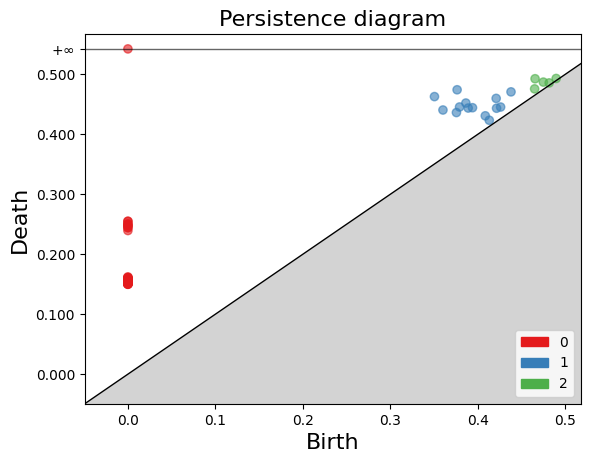

In [21]:
import matplotlib.pyplot as plt
gudhi.plot_persistence_diagram(persistence)
plot_filename = f'diagram frame1047151'
plt.savefig(plot_filename, bbox_inches='tight',dpi=600)

<Axes: title={'center': 'Persistence barcode'}>

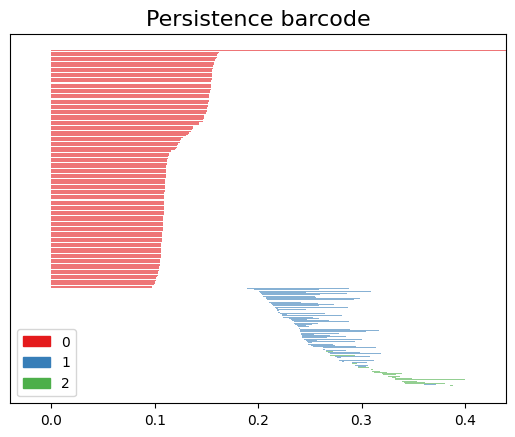

In [38]:
gudhi.plot_persistence_barcode(persistence)

persistence

# Specify the birth and death times of interest (modify as needed)
birth_time = 0.3805802423920519
death_time = 0.4308662774287007

# Find simplices contributing to the birth
birth_simplices = [simplex for simplex, time in simplex_tree.get_simplices() if time == birth_time]

# Find simplices contributing to the death
death_simplices = [simplex for simplex, time in simplex_tree.get_simplices() if time == death_time]
print("Simplices contributing to birth at time", birth_time, ":", birth_simplices)
print("Simplices contributing to death at time", death_time, ":", death_simplices)

first_frame = traj[0]
first_frame.save("first_frame_output.pdb")

In [32]:
frame = traj[0:100]
frame.save("normal100frame.pdb")

In [33]:
a_helix = traj[1047101:1047201]
a_helix.save("ahelix100frame.pdb")

a_helix = traj[1047151]
a_helix.save("ahelix_frame_output.pdb")

def combine_pdbs(file1, file2, output_file):
    with open(file1, 'r') as f1, open(file2, 'r') as f2, open(output_file, 'w') as output:
        frames1 = f1.read().split('ENDMDL')[:-1]  # Split frames in file1
        frames2 = f2.read().split('ENDMDL')[:-1]  # Split frames in file2

        if len(frames1) != len(frames2) or len(frames1) != 100:
            print("Error: Both input files should have 100 frames each.")
            return

        for frame1, frame2 in zip(frames1, frames2):
            output.write(frame1 + 'ENDMDL\n')  # Write frame from file1
            output.write(frame2 + 'ENDMDL\n')  # Write frame from file2

    print("Combination successful. Output saved to", output_file)
combine_pdbs('normal100frame.pdb', 'ahelix100frame.pdb', 'combined200.pdb')

# The generated trajectory alternates between frames from two PDB files.

In [34]:
traj5 = md.load('normal100frame.pdb')
traj5 = md.Trajectory.superpose(traj5, traj5[0], frame=0, atom_indices=None, ref_atom_indices=None, parallel=True)

In [35]:
traj6 = md.load('ahelix100frame.pdb')
traj6 = md.Trajectory.superpose(traj6, traj6[0], frame=0, atom_indices=None, ref_atom_indices=None, parallel=True)

In [36]:
joined_traj = md.join([traj5, traj6])
joined_traj.save('combined200.pdb')

In [ ]:
LS = gd.representations.Landscape(resolution=100)
L = LS.fit_transform([acX.persistence_intervals_in_dimension(1)])